In [1]:
#Jack Baxter
#First Agent

environment loaded


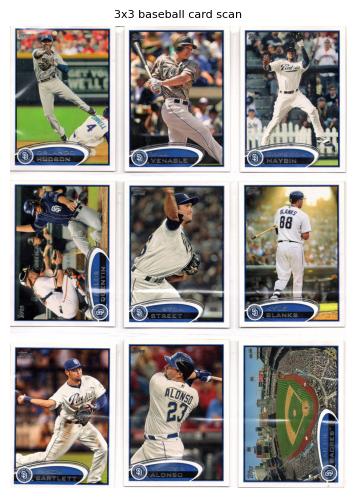

Full scan dimensions: 4795px wide × 6590px tall
Each card region will be: 1598px wide × 2196px tall


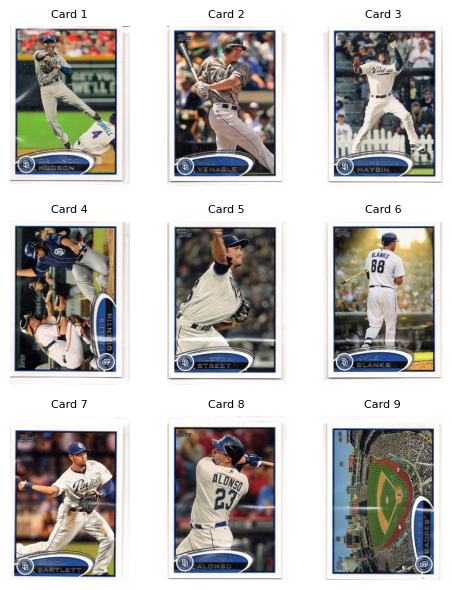

Extracting text from each card...
--Card 1 Text--
(no text detected)


--Card 2 Text--
(no text detected)


--Card 3 Text--
(no text detected)


--Card 4 Text--
(no text detected)


--Card 5 Text--
(no text detected)


--Card 6 Text--
(no text detected)


--Card 7 Text--
(no text detected)


--Card 8 Text--
(no text detected)


--Card 9 Text--
(no text detected)




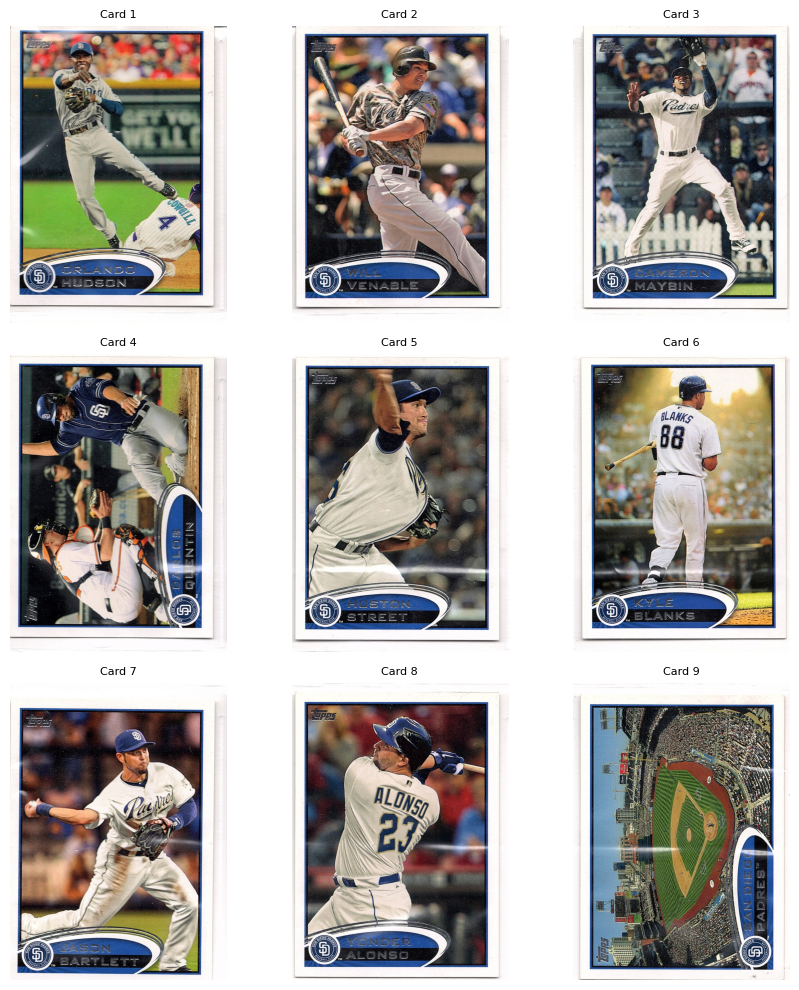

In [2]:
#import helper functions from utils.py
from utils import load_env, get_api_keys

#import libs for working with images
from PIL import Image
from PIL import ImageOps
import matplotlib.pyplot as plt
import base64
import json


#import opencv for image processing 
import cv2
import numpy as np

#import requests library 
import requests 

#import OCR library
import pytesseract

#load the .env file from utils function
load_env()

#get path to scanned image
#put image in data folder 
#initialize path
image_path = "baseball1.jpg"

#load image and display it
img = Image.open(image_path)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.title('3x3 baseball card scan', fontsize=8)
plt.show()

#reload scan with opencv
img_cv = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

#get the dimensions of the image
height, width, _ = img_rgb.shape
print(f"Full scan dimensions: {width}px wide × {height}px tall")
print(f"Each card region will be: {width//3}px wide × {height//3}px tall")

#card dimenstion ratio
card_width = width // 3
card_height = height // 3
cropped_cards = []
for row in range(3):
    for col in range(3):
        x1 = col * card_width
        x2 = (col + 1) * card_width
        y1 = row * card_height
        y2 = (row + 1) * card_height
        
        card = img_rgb[y1:y2, x1:x2]
        cropped_cards.append(card)

# Display the 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(5, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(cropped_cards[i])
    ax.axis('off')
    ax.set_title(f"Card {i+1}", fontsize=8)
plt.tight_layout()
plt.show()

#use OCR to extract text from each card
#potentiall preproc here: 
#def enhance_card(card_pil):
#    return ImageOps.invert(ImageOps.grayscale(card_pil)).point(lambda x: 0 if x < 140 else 255)

#run OCR on each card
print('Extracting text from each card...')

fig, axes = plt.subplots(3, 3, figsize=(9, 10))
for i, card_rgb in enumerate(cropped_cards):
    #convert to PIL image
    card_pil = Image.fromarray(card_rgb)
    #optional preproc here
    #card_pil = enhance_card(card_pil)

    #run OCR
    text = pytesseract.image_to_string(card_pil)

    #display card 
    ax = axes.flat[i]
    ax.imshow(card_rgb)
    ax.axis('off')
    ax.set_title(f'Card {i+1}', fontsize=8)

    #print extracted text below
    print(f'--Card {i+1} Text--')
    print(text if text else '(no text detected)')
    print('\n')

plt.tight_layout()
plt.show()